# <font  color = "#0093AF"> Exchange in 1D spectra

In [3]:
import os
os.chdir('../../../')
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Build the system
The first step is to build the system, which will have a single nucleus, with two different chemical shifts.

In [6]:
ex0=sl.ExpSys(Nucs='13C',v0H=600)    #We need a description of the experiment for both states (ex0, ex1)
ex1=ex0.copy()
ex0.set_inter(Type='CS',i=0,ppm=-5)   #Add the chemical shifts
_=ex1.set_inter(Type='CS',i=0,ppm=5)

## Add the exchange process (symmetric exchange)
First, export this sytem into Liouville space, allowing us to introduce an exchange process. Then we'll define a correlation time and population 1 and population 2. Here we start assuming the populations, $p_1$ and $p_2$ are equal

In [7]:
L=sl.Liouvillian((ex0,ex1))           #Builds the two different Hamiltonians and exports them to Liouville space

tc=1e-3     #Correlation time (10 s)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2

kex=1/(2*tc)*(np.array([[-1,1],[1,-1]])+(p1-p2)*np.array([[1,1],[-1,-1]]))
#This can also be obtained from kex=sl.Tools.twoSite_kex(tc=tc,p1=p1)
L.kex=kex

## Run as a 1D Experiment
We'll start the magnetization on $S_x$ and observe $S^+$. We need a propagator from the Liouville matrix.

In [17]:
rho=sl.Rho(rho0='13Cx',detect='13Cp')
#For a 10 ppm shift difference, Dt should be short enough to capture both peaks in the spectrum
Dt=1/(2*10*150)
# Empty sequence
seq=L.Sequence(Dt=Dt)  #For solution NMR, Dt must be specified

_=rho.DetProp(seq,n=1024)

State-space reduction: 8->2


Note that rho.DetProp has reduced the Liouvillian from an 8x8 matrix to a 2x2 matrix. The 2x2 matrix is the familiar matrix obtained while solving the Bloch-McConnel equations

$$
\begin{equation}
\hat{\hat{L}}_{red.}=
\begin{pmatrix}
-k_{12}+i\Omega_1 & k_{21} \\
k_{12} & k_{21}+i\Omega_2
\end{pmatrix}
\end{equation}
$$

This sub-matrix of $\hat{\hat{L}}$ corresponds to the $\hat{S}^+$ terms that are being detected. While we also start out with $\hat{S}^-$, they don't exchange with the $\hat{S}^+$ terms, and are also not detected, so we don't need to actually calculate them.

## Plot the results

In this timescale, we still obtain two peaks, but that are strongly broadened by the exchange process. We can sweep the correlation time to observe the coalescence of the peaks.

<AxesSubplot:xlabel='$\\nu$ / Hz', ylabel='I / a.u.'>

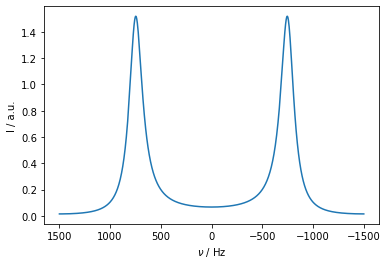

In [18]:
rho.plot(FT=True)

## Sweep through a range of correlation times to observe coalescence

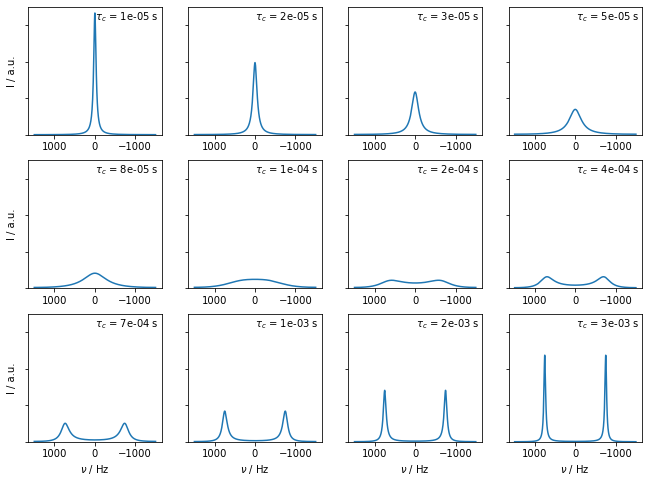

In [30]:
sl.Defaults['verbose']=False  #If SLEEPY outputs get annoying, you can turn them off
tc0=np.logspace(-5,-2.5,12) #Correlation times to sweep through
fig,ax=plt.subplots(3,4) # Plots to show data
fig.set_size_inches([11,8]) # Make the figure bigger
ax=ax.flatten() #ax is a 3x4 matrix of axes to plot into. This makes it 1D for the for loop
sm=0
for tc,a in zip(tc0,ax):
    L.kex=sl.Tools.twoSite_kex(tc=tc)
    rho.clear()
    rho.DetProp(seq,n=1024)
    rho.plot(FT=True,ax=a)
    sm=max(sm,a.get_ylim()[1]) #Find maximum axis limit

#make the plots nicers (this is just python, not sleepy functions)
for tc,a in zip(tc0,ax):
    a.set_ylim([0,sm])
    if not(a.is_last_row()):
        a.set_xlabel('')
    if not(a.is_first_col()):
        a.set_ylabel('')
    a.set_yticklabels('')
    a.text(-10,sm*.9,r'$\tau_c$'+f' = {tc:.0e} s')

## Repeat with asymmetric exchange
In symmetic exchange, we can obtain the peak positions and linewidths by diagonalizing the following equation:

$$
\begin{equation}
\hat{\hat{L}}=
\begin{pmatrix}
-k+i\Delta\Omega/2 & k \\
k & -k-i\Delta\Omega/2
\end{pmatrix}
\end{equation}
$$

In this case, the eigenvalues are
$$
\begin{equation}
\lambda=-k\pm\sqrt{k^2-\frac14\Delta\Omega^2}
\end{equation}
$$
Below coalescence

On the other hand, if $k_{12}\ne k_{21}$, then no well-defined coalescence condition exists.

In [12]:
p1=0.75
p2=1-p1

sl.Defaults['verbose']=False  #If SLEEPY outputs get annoying, you can turn them off
tc0=np.logspace(-5,-2.5,12) #Correlation times to sweep through
fig,ax=plt.subplots(3,4) # Plots to show data
fig.set_size_inches([11,8]) # Make the figure bigger
ax=ax.flatten() #ax is a 3x4 matrix of axes to plot into. This makes it 1D for the for loop
sm=0
for tc,a in zip(tc0,ax):
    L.kex=sl.Tools.twoSite_kex(tc=tc)
    rho.clear()
    rho.DetProp(seq,n=1024)
    rho.plot(FT=True,ax=a)
    sm=max(sm,a.get_ylim()[1]) #Find maximum axis limit

#make the plots nicers (this is just python, not sleepy functions)
for tc,a in zip(tc0,ax):
    a.set_ylim([0,sm])
    if a.is_last_row():
        a.set_xlabel(r'$\delta (^{13}$C) / ppm')
    if a.is_first_col():
        a.set_ylabel('I / a.u.')
    a.set_yticklabels('')
    a.text(-10,sm*.9,r'$\tau_c$'+f' = {tc:.0e} s')

Plot the results

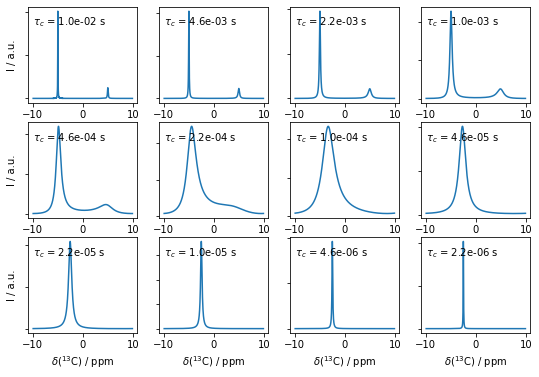

In [13]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches([9,6])
ax=ax.reshape(ax.size)
sm=0
for S0,a in zip(S,ax):
    a.plot(rho.v_axis/ex0.v0[0]*1e6,S0)
    if a.is_last_row():
        a.set_xlabel(r'$\delta (^{13}$C) / ppm')
    if a.is_first_col():
        a.set_ylabel('I / a.u.')
    a.set_yticklabels('')
    sm=max(sm,S0.max())
for a,tc in zip(ax,tc0):
    a.text(-10,a.get_ylim()[1]*.8,r'$\tau_c$'+f' = {tc:.1e} s')